# Forecasting US Inflation with Random Forests

**Paper:** https://doi.org/10.1080/07350015.2019.1637745

## Set up

Import the dependencies.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

Define a function for transforming the time series.

In [2]:
def transform_series(x, tcode):
    '''
    Transform the time series.

    Parameters:
    ______________________________________________________________
    x: pandas.Series
        Time series.

    tcode: int.
        Transformation code.
    '''
    
    if tcode == 1:
        return x
    elif tcode == 2:
        return x.diff()
    elif tcode == 3:
        return x.diff().diff()
    elif tcode == 4:
        return np.log(x)
    elif tcode == 5:
        return np.log(x).diff()
    elif tcode == 6:
        return np.log(x).diff().diff()
    elif tcode == 7:
        return x.pct_change()
    else:
        raise ValueError(f"unknown `tcode` {tcode}")

Define a function for downloading and processing the training data.

In [3]:
def get_training_data(year, month, target_name, target_tcode):
    '''
    Download and process the training data.

    Parameters:
    ______________________________________________________________
    year: int
        The year of the dataset vintage.

    month: int.
        The month of the dataset vintage.

    target_name: string.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.
    '''
    
    # get the dataset URL
    file = f"https://files.stlouisfed.org/files/htdocs/fred-md/monthly/{year}-{format(month, '02d')}.csv"
    
    # get the time series
    data = pd.read_csv(file, skiprows=[1], index_col=0)
    data.columns = [c.upper() for c in data.columns]

    # move the target to the first column
    data = data[[target_name] + data.columns.drop(target_name).tolist()]
    
    # process the dates
    data = data.loc[pd.notna(data.index), :]
    data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))

    # get the transformation codes
    tcodes = pd.read_csv(file, nrows=1, index_col=0)
    tcodes.columns = [c.upper() for c in tcodes.columns]
    
    # override the target's transformation code
    tcodes[target_name] = target_tcode

    # transform the time series
    data = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))

    # select the data after January 1960
    data = data[data.index >= pd.Timestamp("1960-01-01")]
    
    # select the time series without missing values
    data = data.loc[:, data.isna().sum() == 0]
    
    # lag the features
    data = data[[target_name]].join(data.shift(periods=[1], suffix="_LAG"))

    # drop the missing value resulting from taking the lag
    return data.iloc[1:]

Define a function for extracting the target values from a range of dataset vintages.

In [4]:
def get_target(start_month, start_year, end_month, end_year, target_name, target_tcode):
    '''
    Extract the target time series from a range of dataset vintages.

    Parameters:
    ______________________________________________________________
    start_month: int.
        The month of the first vintage.

    start_year: int.
        The year of the first vintage.

    end_month: int.
        The month of the last vintage.

    end_year: int.
        The year of the last vintage.

    target_name: str.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.
        If None, the target time series is not transformed.
    '''

    # create a data frame for storing the target values
    target = pd.DataFrame()
    
    # define the date range of the dataset vintages
    dates = pd.date_range(
        start=f"{start_year}-{start_month}-01",
        end=f"{end_year}-{end_month}-01",
        freq="MS"
    )
    
    # loop across the dataset vintages
    for date in dates:
        
        # get the dataset URL
        file = f"https://files.stlouisfed.org/files/htdocs/fred-md/monthly/{date.year}-{format(date.month, '02d')}.csv"
        
        # get the time series
        data = pd.read_csv(file, skiprows=[1], index_col=0)
        data.columns = [c.upper() for c in data.columns]

        # process the dates
        data = data.loc[pd.notna(data.index), :]
        data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))
        
        # select the target time series
        data = data[[target_name]]
        
        # transform the target time series
        if target_tcode is not None:
            data[target_name] = transform_series(data[target_name], target_tcode)
        
        # select the last value and save it in the data frame
        target = pd.concat([target, data.iloc[-1:]], axis=0)

    return target

Define a function for extracting the feature values from a range of dataset vintages.

In [5]:
def get_features(start_month, start_year, end_month, end_year, target_name, target_tcode, feature_names):
    '''
    Extract the feature time series from a range of dataset vintages.

    Parameters:
    ______________________________________________________________
    start_month: int.
        The month of the first vintage.

    start_year: int.
        The year of the first vintage.

    end_month: int.
        The month of the last vintage.

    end_year: int.
        The year of the last vintage.

    target_name: str.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.

    feature_names: list of str.
        The names of the features time series.
    '''

    # create a data frame for storing the feature values
    features = pd.DataFrame()
    
    # define the date range of the dataset vintages
    dates = pd.date_range(
        start=f"{start_year}-{start_month}-01",
        end=f"{end_year}-{end_month}-01",
        freq="MS"
    )

    # loop across the dataset vintages
    for date in dates:
        
        # get the dataset URL
        file = f"https://files.stlouisfed.org/files/htdocs/fred-md/monthly/{(date - pd.offsets.MonthBegin(1)).year}-{format((date - pd.offsets.MonthBegin(1)).month, '02d')}.csv"
        
        # get the time series
        data = pd.read_csv(file, skiprows=[1], index_col=0)
        data.columns = [c.upper() for c in data.columns]
        
        # process the dates
        data = data.loc[pd.notna(data.index), :]
        data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))

        # get the transformation codes
        tcodes = pd.read_csv(file, nrows=1, index_col=0)
        tcodes.columns = [c.upper() for c in tcodes.columns]
        
        # override the target's transformation code
        tcodes[target_name] = target_tcode
        
        # transform the time series
        data = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))
        
        # rename the time series
        data.columns = [c + "_LAG_1" for c in data.columns]
        
        # drop any features that were not used for training
        data = data[feature_names]
        
        # forward fill any missing values
        data = data.ffill()

        # shift the dates one month forward
        data.index += pd.offsets.MonthBegin(1)
        
        # select the last values and save them in the data frame
        features = pd.concat([features, data.iloc[-1:]], axis=0)
    
    return features

Define a function for downloading and processing the test data.

In [6]:
def get_test_data(start_month, start_year, end_month, end_year, target_name, target_tcode, feature_names):
    '''
    Download and process the test data.

    Parameters:
    ______________________________________________________________
    start_month: int.
        The month of the first vintage.

    start_year: int.
        The year of the first vintage.

    end_month: int.
        The month of the last vintage.

    end_year: int.
        The year of the last vintage.

    target_name: str.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.

    feature_names: list of str.
        The names of the features time series.
    '''

    # get the targets
    target = get_target(
        start_year=start_year,
        start_month=start_month,
        end_year=end_year,
        end_month=end_month,
        target_name=target_name,
        target_tcode=target_tcode,
    )

    # get the features
    features = get_features(
        start_year=start_year,
        start_month=start_month,
        end_year=end_year,
        end_month=end_month,
        target_name=target_name,
        target_tcode=target_tcode,
        feature_names=feature_names
    )
    
    return target.join(features)

Define a function for training the random forest model and generating the forecasts.

In [7]:
def run_random_forest_model(params, train_dataset, test_dataset, target_name):
    '''
    Run the random forest model.

    Parameters:
    ______________________________________________________________
    params: dict.
        The random forest hyperparameters
 
    train_dataset: pandas.DataFrame.
        Training dataset.

    test_dataset: pandas.DataFrame.
        Test dataset.

    target_name: str.
        The name of the target time series.
    '''
        
    # instantiate the model
    model = RandomForestRegressor(**params)
    
    # fit the model to the training set
    model.fit(
        X=train_dataset.drop([target_name], axis=1),
        y=train_dataset[target_name]
    )
    
    # generate the forecasts over the test set
    return pd.Series(
        data=model.predict(X=test_dataset.drop([target_name], axis=1)),
        index=test_dataset.index
    )

Define a function for training the AR(1) model and generating the forecasts.

In [8]:
def run_autoregressive_model(train_dataset, test_dataset, target_name):
    '''
    Run the AR(1) model.

    Parameters:
    ______________________________________________________________
    train_dataset: pandas.DataFrame.
        Training dataset.

    test_dataset: pandas.DataFrame.
        Validation dataset.

    target_name: str.
        The name of the target time series.
    '''
    
    # instantiate the model
    model = LinearRegression(fit_intercept=True)
    
    # fit the model to the training set
    model.fit(
        X=train_dataset[[target_name + "_LAG_1"]],
        y=train_dataset[target_name]
    )
    
    # generate the forecasts over the test set
    return pd.Series(
        data=model.predict(X=test_dataset[[target_name + "_LAG_1"]]),
        index=test_dataset.index
    )

Define a function for tuning the random forest hyperparameters.

In [9]:
def tune_random_forest_model(train_dataset, valid_dataset, target_name, n_trials):
    '''
    Tune the random forest hyperparameters.

    Parameters:
    ______________________________________________________________
    train_dataset: pandas.DataFrame.
        Training dataset.

    valid_dataset: pandas.DataFrame.
        Validation dataset.

    target_name: str.
        The name of the target time series.
    
    n_trials: int.
        The number of random search iterations.
    '''
    
    # define the objective function
    def objective(trial):
        
        # sample the hyperparameters
        params = {
            "criterion": trial.suggest_categorical("criterion", choices=["absolute_error", "squared_error"]),
            "n_estimators": trial.suggest_int("n_estimators", low=10, high=100),
            "max_features": trial.suggest_float("max_features", low=0.6, high=1.0),
            "max_samples": trial.suggest_float("max_samples", low=0.6, high=1.0),
            "max_depth": trial.suggest_int("max_depth", low=1, high=100),
            "random_state": trial.suggest_categorical("random_state", choices=[42]),
            "n_jobs": trial.suggest_categorical("n_jobs", choices=[-1])
        }
        
        # calculate the root mean squared error of the forecasts
        return root_mean_squared_error(
            y_true=valid_dataset[target_name],
            y_pred=run_random_forest_model(
                params=params,
                train_dataset=train_dataset,
                test_dataset=valid_dataset,
                target_name=target_name
            )
        )

    # minimize the objective function
    study = optuna.create_study(
        sampler=optuna.samplers.RandomSampler(seed=42),
        direction="minimize"
    )
    
    study.optimize(
        func=objective,
        n_trials=n_trials
    )
    
    # return the best hyperparameters
    return study.best_params

Define the target name.

In [10]:
target_name = "CPIAUCSL"

Define the target transformation code.

In [11]:
target_tcode = 5

## Hyperparameter tuning

Load the training data.

In [12]:
train_dataset = get_training_data(
    year=2023,
    month=2,
    target_name=target_name,
    target_tcode=target_tcode
)

In [13]:
train_dataset.shape

(756, 110)

In [14]:
train_dataset.head()

,CPIAUCSL,CPIAUCSL_LAG_1,RPI_LAG_1,W875RX1_LAG_1,DPCERA3M086SBEA_LAG_1,RETAILX_LAG_1,INDPRO_LAG_1,IPFPNSS_LAG_1,IPFINAL_LAG_1,IPCONGD_LAG_1,...,CUSR0000SA0L2_LAG_1,CUSR0000SA0L5_LAG_1,PCEPI_LAG_1,DDURRG3M086SBEA_LAG_1,DNDGRG3M086SBEA_LAG_1,DSERRG3M086SBEA_LAG_1,CES0600000008_LAG_1,CES2000000008_LAG_1,CES3000000008_LAG_1,INVEST_LAG_1
1960-02-01,0.001361,-0.001361,0.003194,0.004638,0.002788,0.026606,0.025914,0.024097,0.029021,0.031237,...,-0.003221,-0.006678,-0.001716,-0.002591,-0.001786,-0.001288,-0.004680,0.007797,-0.009705,-0.013330
1960-03-01,0.000000,0.001361,0.001143,0.000917,0.004335,0.003696,-0.008936,-0.005683,-0.003441,-0.011454,...,0.000000,0.006678,0.001593,0.003765,0.001674,0.000855,-0.004555,0.003853,-0.004750,-0.018942
1960-04-01,0.004411,0.000000,0.001909,0.000916,0.014041,-0.001102,-0.009020,-0.003429,-0.001145,0.001151,...,0.000000,-0.003339,-0.000491,-0.004555,0.001786,-0.001113,-0.000020,0.030131,-0.004684,0.003490
1960-05-01,0.001015,0.004411,0.003419,0.003614,0.015355,0.025903,-0.007958,0.002289,0.001145,0.006879,...,0.003210,0.003328,0.003114,0.004119,0.004439,0.001450,-0.008949,-0.068074,0.000000,0.024136
1960-06-01,0.001352,0.001015,0.002401,0.002443,-0.020343,-0.015047,-0.001144,0.005690,0.006866,0.005699,...,-0.000010,-0.003328,-0.002629,-0.001298,-0.006723,0.000591,0.008949,0.041620,0.000000,0.003798


In [15]:
train_dataset.tail()

,CPIAUCSL,CPIAUCSL_LAG_1,RPI_LAG_1,W875RX1_LAG_1,DPCERA3M086SBEA_LAG_1,RETAILX_LAG_1,INDPRO_LAG_1,IPFPNSS_LAG_1,IPFINAL_LAG_1,IPCONGD_LAG_1,...,CUSR0000SA0L2_LAG_1,CUSR0000SA0L5_LAG_1,PCEPI_LAG_1,DDURRG3M086SBEA_LAG_1,DNDGRG3M086SBEA_LAG_1,DSERRG3M086SBEA_LAG_1,CES0600000008_LAG_1,CES2000000008_LAG_1,CES3000000008_LAG_1,INVEST_LAG_1
2022-09-01,0.004119,0.002346,0.002957,0.004051,0.004784,0.006697,-0.001079,0.001196,0.003203,0.001330,...,0.003473,0.002767,0.003610,0.006974,-0.002537,0.004969,-0.001442,0.002759,-0.003595,-0.004031
2022-10-01,0.004871,0.004119,0.001310,0.002391,0.002582,-0.001674,0.001956,-0.001360,-0.002311,-0.005121,...,0.002271,0.001874,0.000758,-0.000350,0.003919,-0.000110,0.001406,-0.000034,0.003171,-0.007420
2022-11-01,0.002048,0.004871,0.004929,0.001923,0.003318,0.010616,0.000179,0.004620,0.007262,0.007908,...,0.001222,0.001716,0.000678,-0.008373,0.012495,-0.001477,0.000331,-0.001553,0.000375,-0.005197
2022-12-01,0.001312,0.002048,0.001898,0.001797,-0.003194,-0.010802,-0.005831,-0.005445,-0.006610,-0.005735,...,-0.003817,-0.003040,-0.002456,-0.001749,-0.008829,-0.000520,0.001026,-0.000624,0.003892,0.009257
2023-01-01,0.005157,0.001312,0.001156,0.001590,-0.003321,-0.010998,-0.010236,-0.008693,-0.006204,-0.001970,...,-0.001838,-0.001376,0.000349,0.003440,-0.006173,0.001815,-0.001776,0.002399,-0.007070,0.007180


Tune the hyperparameters.

In [16]:
params = tune_random_forest_model(
    train_dataset=train_dataset.iloc[:-12],
    valid_dataset=train_dataset.iloc[-12:],
    target_name=target_name,
    n_trials=30
)

[I 2024-03-22 13:25:06,488] A new study created in memory with name: no-name-35c7dd4f-9f0d-477b-855c-37e023f78301
[I 2024-03-22 13:25:06,918] Trial 0 finished with value: 0.004399600919406098 and parameters: {'criterion': 'squared_error', 'n_estimators': 76, 'max_features': 0.8394633936788146, 'max_samples': 0.6624074561769746, 'max_depth': 16, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.004399600919406098.
[I 2024-03-22 13:25:07,272] Trial 1 finished with value: 0.00406731551768406 and parameters: {'criterion': 'squared_error', 'n_estimators': 64, 'max_features': 0.8832290311184181, 'max_samples': 0.608233797718321, 'max_depth': 97, 'random_state': 42, 'n_jobs': -1}. Best is trial 1 with value: 0.00406731551768406.
[I 2024-03-22 13:25:08,019] Trial 2 finished with value: 0.0038884493850186836 and parameters: {'criterion': 'absolute_error', 'n_estimators': 26, 'max_features': 0.6733618039413735, 'max_samples': 0.7216968971838151, 'max_depth': 53, 'random_state': 42

In [17]:
print(f"Best hyperparameters: {params}")

Best hyperparameters: {'criterion': 'absolute_error', 'n_estimators': 12, 'max_features': 0.6431565707973218, 'max_samples': 0.6125716742746937, 'max_depth': 64, 'random_state': 42, 'n_jobs': -1}


## Model evaluation

Load the test data.

In [18]:
test_dataset = get_test_data(
    start_year=2023,
    start_month=3,
    end_year=2024,
    end_month=2,
    target_name=target_name,
    target_tcode=target_tcode,
    feature_names=train_dataset.columns.drop(target_name).tolist()
)

In [19]:
test_dataset.shape

(12, 110)

In [20]:
test_dataset.head()

,CPIAUCSL,CPIAUCSL_LAG_1,RPI_LAG_1,W875RX1_LAG_1,DPCERA3M086SBEA_LAG_1,RETAILX_LAG_1,INDPRO_LAG_1,IPFPNSS_LAG_1,IPFINAL_LAG_1,IPCONGD_LAG_1,...,CUSR0000SA0L2_LAG_1,CUSR0000SA0L5_LAG_1,PCEPI_LAG_1,DDURRG3M086SBEA_LAG_1,DNDGRG3M086SBEA_LAG_1,DSERRG3M086SBEA_LAG_1,CES0600000008_LAG_1,CES2000000008_LAG_1,CES3000000008_LAG_1,INVEST_LAG_1
2023-02-01,0.003693,0.005157,-0.000347,0.000936,0.011287,0.029199,0.000261,-0.000201,-0.001112,-0.006839,...,0.006075,0.004742,0.004167,0.004755,0.014262,0.000852,0.003446,-0.000635,0.006209,0.000375
2023-03-01,0.000530,0.003693,0.000598,0.000319,-0.001091,-0.004013,-0.000162,-0.000209,-0.000562,0.000634,...,-0.002489,-0.001442,-0.003087,-0.004258,-0.004117,-0.002520,-0.005211,-0.001524,-0.007376,-0.005326
2023-04-01,0.003671,0.000530,0.002233,0.002955,-0.000308,-0.006407,0.003761,0.004413,0.005011,0.009279,...,-0.003796,-0.003652,-0.002246,0.001001,-0.006456,-0.001531,0.003095,0.001158,0.006580,-0.020869
2023-05-01,0.001240,0.003671,-0.000087,0.001631,0.004705,0.004197,0.004777,0.005254,0.007446,0.005905,...,0.005506,0.003175,0.002612,0.002875,0.006584,0.001292,-0.001052,-0.001504,-0.002331,0.001851
2023-06-01,0.001802,0.001240,0.002734,0.002977,-0.000253,0.003443,-0.001592,-0.000508,-0.000884,-0.001138,...,-0.004438,-0.002733,-0.002341,0.000346,-0.007018,-0.001353,0.001352,0.000573,0.003050,0.016071


In [21]:
test_dataset.tail()

,CPIAUCSL,CPIAUCSL_LAG_1,RPI_LAG_1,W875RX1_LAG_1,DPCERA3M086SBEA_LAG_1,RETAILX_LAG_1,INDPRO_LAG_1,IPFPNSS_LAG_1,IPFINAL_LAG_1,IPCONGD_LAG_1,...,CUSR0000SA0L2_LAG_1,CUSR0000SA0L5_LAG_1,PCEPI_LAG_1,DDURRG3M086SBEA_LAG_1,DNDGRG3M086SBEA_LAG_1,DSERRG3M086SBEA_LAG_1,CES0600000008_LAG_1,CES2000000008_LAG_1,CES3000000008_LAG_1,INVEST_LAG_1
2023-09-01,0.003949,0.006292,-0.000134,0.001045,0.000541,0.005591,0.003840,0.001599,0.001606,-0.001942,...,0.007905,0.004691,0.001799,0.003900,0.013939,-0.002461,-0.000014,-0.000612,0.000365,-0.005764
2023-10-01,0.000449,0.003949,-0.000194,0.000725,0.003831,0.007117,0.002846,0.001890,0.000953,0.002575,...,-0.005501,-0.002583,-0.000137,0.002269,-0.010709,0.002813,0.000321,-0.001766,0.001500,0.003264
2023-11-01,0.000968,0.000449,0.001963,0.002760,0.001695,-0.001059,-0.006369,-0.006819,-0.008791,-0.011964,...,-0.003701,-0.003913,-0.003205,-0.001796,-0.006107,-0.002528,-0.001687,0.002020,-0.003018,-0.004894
2023-12-01,0.003025,0.000968,0.004228,0.005755,0.003200,0.002759,0.002401,0.001836,0.002633,0.000753,...,0.000170,0.000365,-0.001064,-0.001501,-0.005675,0.000486,0.005307,0.003420,0.006346,0.009452
2024-01-01,0.003050,0.003025,0.000898,0.001480,0.005399,0.005522,0.000526,0.000143,0.001102,0.001936,...,0.003119,0.002249,0.002341,0.000330,0.008233,0.000786,-0.003355,-0.009196,0.001413,0.018581


Run the random forest model.

In [22]:
rf_forecasts = run_random_forest_model(
    params=params,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    target_name=target_name
)

Run the AR(1) model.

In [23]:
ar1_forecasts = run_autoregressive_model(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    target_name=target_name,
)

Save the forecasts.

In [24]:
forecasts = pd.DataFrame({
    target_name: test_dataset[target_name],
    "RF": rf_forecasts,
    "AR(1)": ar1_forecasts,
})

In [25]:
forecasts

,CPIAUCSL,RF,AR(1)
2023-02-01,0.003693,0.004287,0.004383
2023-03-01,0.000530,0.002767,0.003467
2023-04-01,0.003671,0.002807,0.001490
2023-05-01,0.001240,0.003693,0.003454
2023-06-01,0.001802,0.002637,0.001934
2023-07-01,0.001667,0.003432,0.002285
2023-08-01,0.006292,0.004987,0.002201
2023-09-01,0.003949,0.004914,0.005092
2023-10-01,0.000449,0.003274,0.003628
2023-11-01,0.000968,0.001277,0.001439


In [26]:
forecasts.to_csv("forecasts.csv")

Visualize the forecasts.

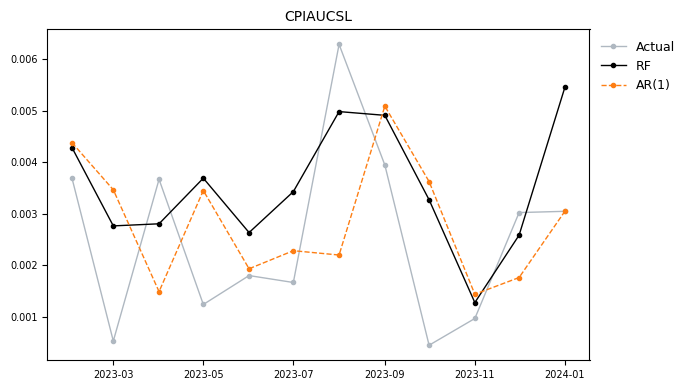

In [27]:
plt.subplots(figsize=(7, 4))
plt.plot(forecasts[target_name], "-o", color="#AFB8C1", lw=1, markersize=3, label="Actual")
plt.plot(forecasts["RF"], "-o", color="#000000", lw=1, markersize=3, label="RF")
plt.plot(forecasts["AR(1)"], "o--", color="#fd7e14", lw=1, markersize=3, label="AR(1)")
plt.tick_params(axis="both", which="major", labelsize=7)
plt.tick_params(axis="both", which="minor", labelsize=7)
plt.legend(bbox_to_anchor=(1, 0, 0, 1), frameon=False, prop={"size": 9})
plt.title(target_name, size=10)
plt.tight_layout()
plt.show()

Calculate the root mean squared error of the forecasts.

In [28]:
rf_error = root_mean_squared_error(
    y_true=forecasts[target_name],
    y_pred=forecasts["RF"],
)

In [29]:
ar1_error = root_mean_squared_error(
    y_true=forecasts[target_name],
    y_pred=forecasts["AR(1)"],
)

In [30]:
hm_error = root_mean_squared_error(
    y_true=forecasts[target_name],
    y_pred=train_dataset[target_name].iloc[- len(forecasts):].mean() * np.ones(len(forecasts)),
)

In [31]:
print(f"RF RMSE: {format(rf_error, '.6f')}")
print(f"AR(1) RMSE: {format(ar1_error, '.6f')}")
print(f"Historical Mean RMSE: {format(hm_error, '.6f')}")

RF RMSE: 0.001649
AR(1) RMSE: 0.002023
Historical Mean RMSE: 0.003084


In [32]:
print(f"RF - AR(1) % difference: {format(rf_error / ar1_error - 1, '.3%')}")
print(f"RF - Historical Mean % difference: {format(rf_error / hm_error - 1, '.3%')}")

RF - AR(1) % difference: -18.500%
RF - Historical Mean % difference: -46.542%
